In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

In [ ]:
MODEL_CHECKPOINT = "microsoft/deberta-v3-base"

In [ ]:
def train_model(data_files, label_col):
    dataset = load_dataset("csv", data_files={"train": data_files})

    # labels -> integers
    label2id = {
        "entailment": 0,
        "neutral": 1,
        "contradiction": 2
    }

    id2label = {v: k for k, v in label2id.items()}

    def encode_labels(batch):
        batch["labels"] = label2id[batch[label_col]]
        return batch

    dataset = dataset["train"].map(encode_labels)

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

    def tokenize_fn(batch):
        return tokenizer(
            batch["sentence1"],
            batch["sentence2"],
            truncation=True
        )

    dataset = dataset.map(tokenize_fn, batched=True)

    # Remove non-tensor columns
    dataset = dataset.remove_columns(["sentence1", "sentence2", label_col])

    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        "microsoft/deberta-v3-base",
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )
    
    training_args = TrainingArguments(
        output_dir="./nli_model",
        per_device_train_batch_size=16,
        num_train_epochs=3,
        learning_rate=2e-5,
        logging_steps=50,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        data_collator=collator,
        tokenizer=tokenizer,
    )

    trainer.train()

    return trainer, tokenizer


In [ ]:
trainer, tokenizer = train_model(data_files="/content/sample_data/predictions_train_gpt-4o-mini_1500.csv", label_col="pred_label")

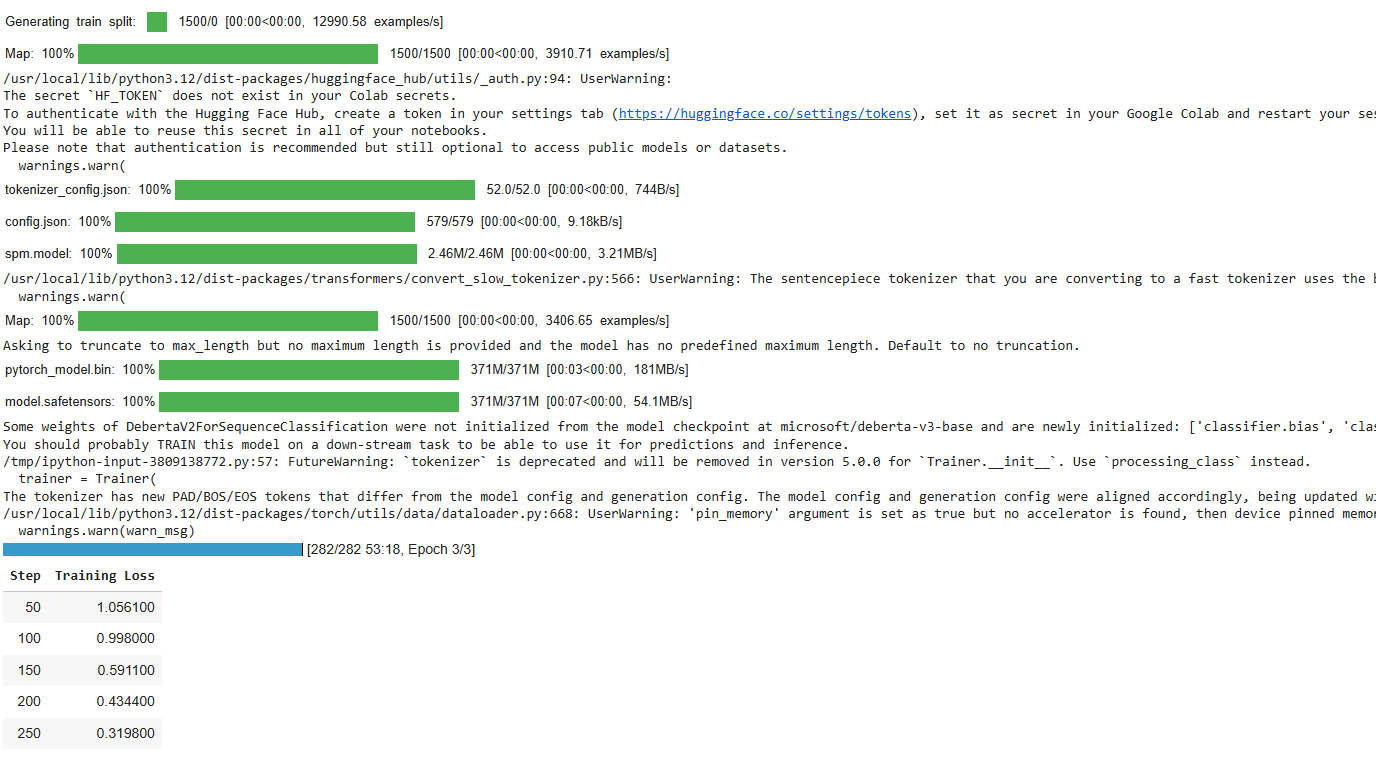

In [ ]:
trainer, tokenizer = train_model(data_files="/content/sample_data/snli_test_sample_1500.csv", label_col="gold_label")

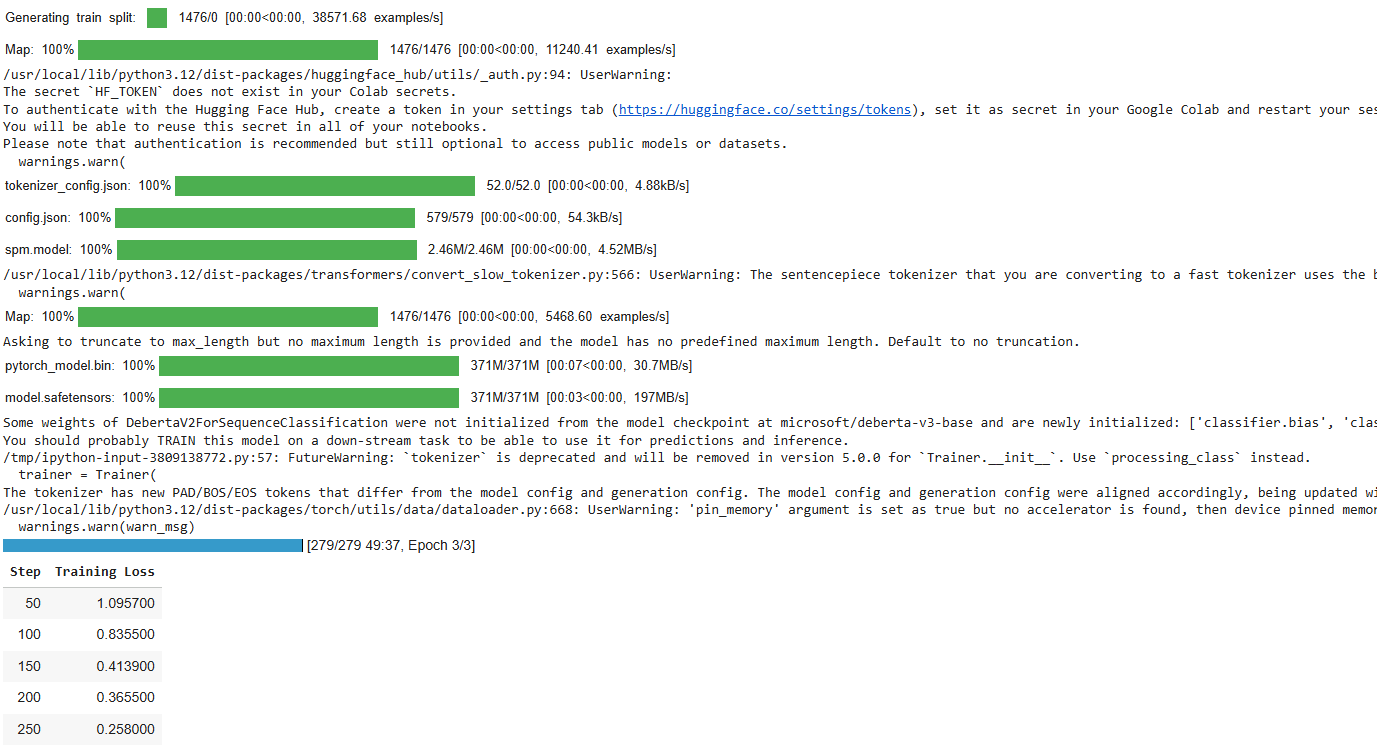

In [ ]:
def evaluate_on_test(trainer, tokenizer, test_path, target_col_name, model_run_name):
    test_dataset = load_dataset("csv", data_files=test_path)["train"]
    
    sentences1 = test_dataset["sentence1"]
    sentences2 = test_dataset["sentence2"]
    
    def tokenize_fn(batch):
        return tokenizer(
            batch["sentence1"], 
            batch["sentence2"], 
            truncation=True,
            padding=False 
        )
    
    tokenized_test = test_dataset.map(tokenize_fn, batched=True)
    
    label2id = {
        "entailment": 0,
        "neutral": 1,
        "contradiction": 2
    }
    id2label = {v: k for k, v in label2id.items()}

    def encode_labels(batch):
        val = batch[target_col_name]
        if isinstance(val, int):
            batch["labels"] = val
        else:
            batch["labels"] = label2id[val]
        return batch

    tokenized_test = tokenized_test.map(encode_labels)
    
    keep_cols = ["input_ids", "attention_mask", "labels"]
    if "token_type_ids" in tokenized_test.column_names: 
        keep_cols.append("token_type_ids")
        
    tokenized_test.set_format("torch", columns=keep_cols)
    
    # Предсказание
    predictions = trainer.predict(tokenized_test)
    pred_labels_ids = predictions.predictions.argmax(axis=1)
    true_labels_ids = predictions.label_ids

    # Метрики
    acc = accuracy_score(true_labels_ids, pred_labels_ids)
    print(f"Accuracy: {acc:.4f}")
    
    target_names = ["entailment", "neutral", "contradiction"]
    print(classification_report(
        true_labels_ids, pred_labels_ids,
        target_names=target_names
    ))

    # Матрица ошибок
    cm = confusion_matrix(true_labels_ids, pred_labels_ids)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title(f"Confusion Matrix - {model_run_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


    pred_labels_str = [id2label[i] for i in pred_labels_ids]
    true_labels_str = [id2label[i] for i in true_labels_ids]

    results_df = pd.DataFrame({
        "sentence1": sentences1,
        "sentence2": sentences2,
        "gold_label_id": true_labels_ids,
        "gold_label_str": true_labels_str,
        "pred_label_id": pred_labels_ids,
        "pred_label_str": pred_labels_str,
        "model_name": model_run_name
    })
    
    output_filename = f"predictions_{model_run_name}.csv"
    results_df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")

    return pred_labels_ids, true_labels_ids


In [ ]:
preds, trues = evaluate_on_test(
    trainer=trainer,
    tokenizer=tokenizer,
    test_path='/content/sample_data/snli_test.csv', 
    target_col_name='gold_label', 
    model_run_name='4o_mini',
)

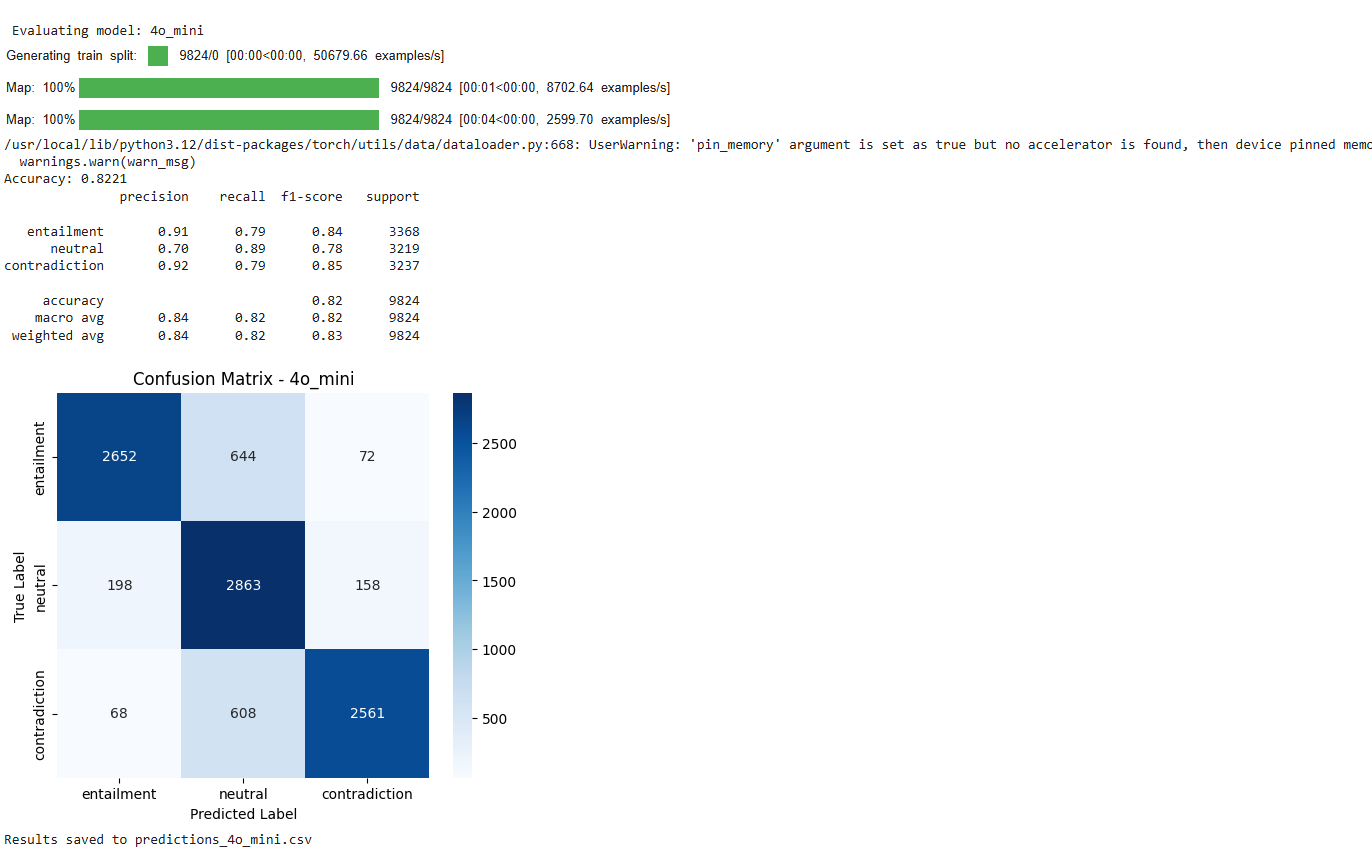

In [ ]:
preds, trues = evaluate_on_test(
    trainer=trainer,
    tokenizer=tokenizer,
    test_path='/content/sample_data/snli_test.csv', 
    target_col_name='gold_label', 
    model_run_name='human',
)

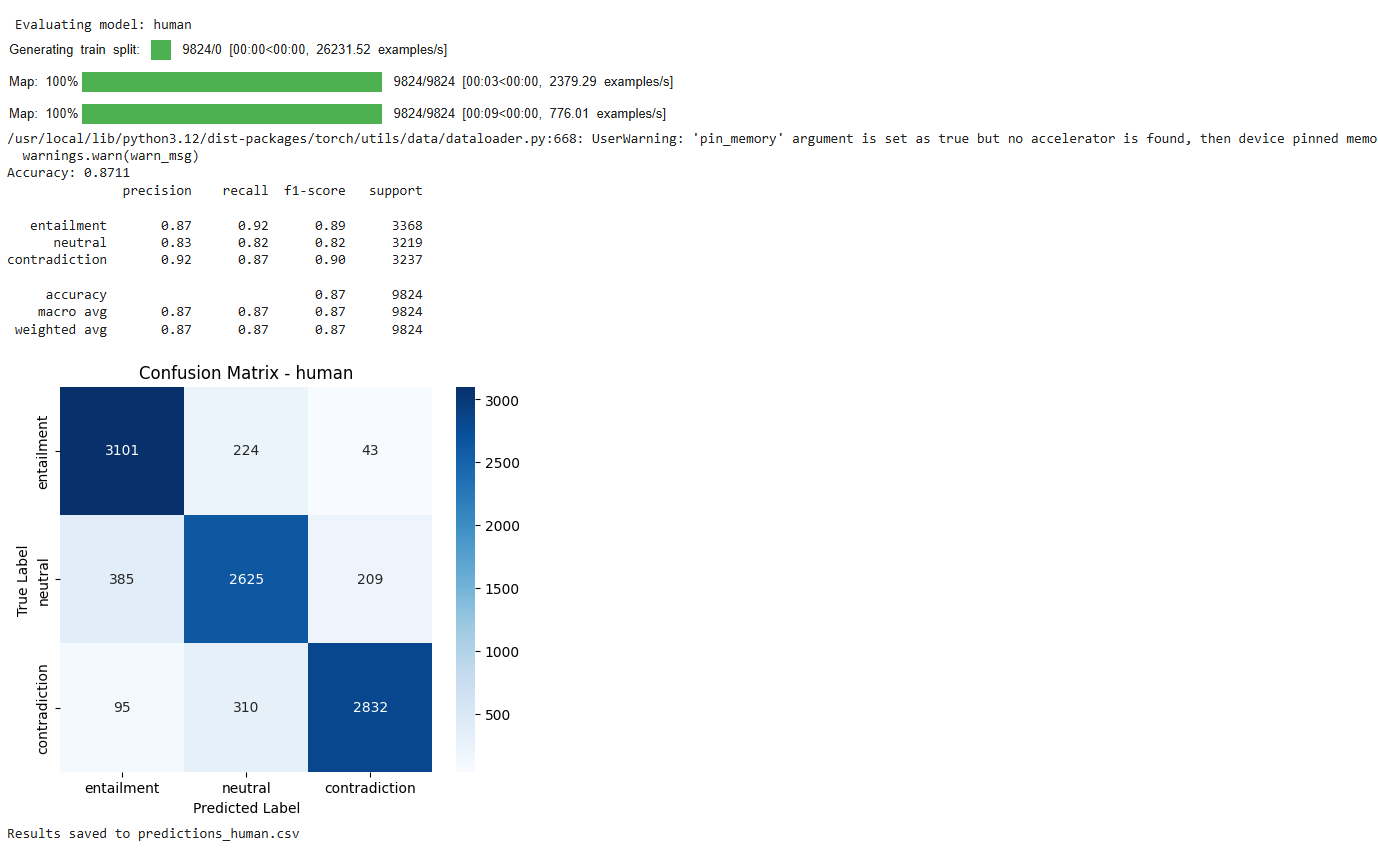